 # Custom training with tf.distribute.Strategy

In [1]:
# Import TensorFlow
import tensorflow as tf
import h5py
import math
import pandas as pd
# Helper libraries
import numpy as np
from numpy.lib.stride_tricks import as_strided
from itertools import chain
import os
import random
import pyarrow as pa
import pyarrow.parquet as pq
print(tf.__version__)
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, Conv2D, MaxPooling2D, Reshape
from keras.optimizers import SGD
from keras import optimizers
from tensorflow.keras import layers
from tensorflow import  keras
import keras
import keras.backend as K
import matplotlib.pyplot as plt
import matplotlib
#tf.enable_eager_execution()

2.10.0


## Create a strategy to distribute the variables and the graph

In [2]:
# If the list of devices is not specified in
# `tf.distribute.MirroredStrategy` constructor, they will be auto-detected.
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [3]:
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


In [4]:
tf.compat.v1.enable_eager_execution()

# Splitting data by Turbofan Unit

## Defining IDS per node

In [5]:
NUMBER_OF_DATASET = 4
FEATURES_PERCENTAGE = 1
VAL_PERCENTAGE = 0.85
BATCH_SIZE = 128
EPOCHS = 540
LEARNING_RATE = 0.01
OUT_PATH = "data/cmapss/processed/"
train_df = pq.read_table(OUT_PATH + 'train_fd00' + str(NUMBER_OF_DATASET)+'.parquet').to_pandas()

In [6]:
# Naming columns to training the model 
SENSOR_COLS = ['s2','s3','s4','s5','s6','s7', 's8','s9','s11','s12','s13','s14','s15','s17','s20','s21']
SEQUENCE_COLS = ['RUL']
TARGET_COLS = ['RUL']
SEQUENCE_COLS.extend(SENSOR_COLS)


In [7]:
SEED=10
NODES=4

random.seed(SEED)
ENGINES = 248
ids = [*range(1,ENGINES+1)]
random.shuffle(ids)
training_ids = ids[:int(len(ids)*VAL_PERCENTAGE)] 
validation_ids = ids[int(len(ids)*VAL_PERCENTAGE):int(len(ids))]
 
#IDS_NODES_TRAIN=[training_ids[x:x+(len(training_ids)+1)//NODES] for x in range(0, len(training_ids)+1, (len(training_ids)+1)//NODES)]
#IDS_NODES_TEST=[validation_ids[x:x+(len(validation_ids)+1)//NODES] for x in range(0, len(validation_ids)+1, (len(validation_ids)+1)//NODES)]
        
IDS_NODES_TRAIN=[ids[:int(len(ids)*VAL_PERCENTAGE)],ids[:int(len(ids)*VAL_PERCENTAGE)],ids[:int(len(ids)*VAL_PERCENTAGE)],ids[:int(len(ids)*VAL_PERCENTAGE)]]
IDS_NODES_TEST=[ids[int(len(ids)*VAL_PERCENTAGE):int(len(ids))],ids[int(len(ids)*VAL_PERCENTAGE):int(len(ids))],ids[int(len(ids)*VAL_PERCENTAGE):int(len(ids))],ids[int(len(ids)*VAL_PERCENTAGE):int(len(ids))]]

## Split data and send Labels to Server

In [8]:
M_LABELS=[*range(0,NODES)]
MAX_DATASET_SIZE=0

for node in range(0,NODES):
    data_node = IDS_NODES_TRAIN[node]
    #random.shuffle(SEQUENCE_COLS)
    sequence_cols_ = SEQUENCE_COLS[:int(len(SEQUENCE_COLS)*FEATURES_PERCENTAGE)]
                
    for x in range(len(data_node)):
        data_trajectory = train_df.loc[train_df['id'] == data_node[x]]
        # Get X and Y data
        if x == 0:
            _train=data_trajectory[sequence_cols_]
        if x != 0:
            _train=_train.append(data_trajectory[sequence_cols_],ignore_index=True)
        if x == len(data_node)-1:
            _train=_train.sample(frac=1, random_state=SEED).reset_index(drop=True)
            X_train=_train[SENSOR_COLS]
            y_train=_train[TARGET_COLS]
            M_LABELS[node]=np.round(y_train.to_numpy(), 3).tolist()
            if (MAX_DATASET_SIZE<y_train.to_numpy().size):
                MAX_DATASET_SIZE=y_train.to_numpy().size

In [9]:
M=np.empty((MAX_DATASET_SIZE,NODES))
print(M.shape)
M[:] = np.nan
for x in range(0,NODES):
    M[:len(M_LABELS[x]),x]=list(chain.from_iterable(M_LABELS[x]))

(51641, 4)


# Calculaling Label Matrix for first Lab (node)

In [10]:
import operator
def labelSynchronization(M, localLab):
    numWorkers = len(list(zip(*M)))
    ID=list(np.unique(M[:,0]))
    synchronizedLabels=np.zeros(M.shape,dtype=int)
    synchronizedLabels[:,localLab]=range(1,len(M)+1);
    if(numWorkers>1):
        labelsAndCounters=np.zeros((len(ID),numWorkers))
        for worker in range(0,numWorkers):
            for _id in range(0,len(ID)):
                labelsAndCounters[_id,worker]=operator.countOf(M[:,worker].tolist(),ID[_id])
        for worker in range(0,numWorkers):
            if worker!=localLab:
                counterPerLabel=np.zeros((len(ID),numWorkers), dtype=int)
                for _id in range(0, len(ID)):
                    element=np.where(M[:, worker]== ID[_id])
                    for row in range(0, len(M)):
                        if (M[row,localLab]== ID[_id]):
                            synchronizedLabels[row,worker]=(list(element)[0])[counterPerLabel[_id,numWorkers-1]]+1
                            counterPerLabel[_id,numWorkers-1] += 1
                            if counterPerLabel[_id,numWorkers-1]>len(element):
                                counterPerLabel[_id,numWorkers-1]=1
    return synchronizedLabels


SYNCHRONIZED_LABELS=labelSynchronization(M, 0)-1

In [11]:
SYNCHRONIZED_LABELS

array([[    0,     0,     0,     0],
       [    1,     1,     1,     1],
       [    2,     2,     2,     2],
       ...,
       [51638,     1,     1,     1],
       [51639,  1256,  1256,  1256],
       [51640,     1,     1,     1]])

## Setup input pipeline

In [12]:
def read_h5_file(resources_path, name):
    # Read numpy array 
    hf = h5py.File(resources_path+name+"-centralized.h5", 'r')
    return np.array(hf[name][:])

In [13]:
nodes = [0,1,2,3] 
model = "mlp"

In [14]:
def batch_data(test, batch_size):
    m,n = test.shape
    S = test.itemsize
    if not batch_size:
        batch_size = m
    count_batches = m//batch_size
    # Batches which can be covered fully
    test_batches = as_strided(test, shape=(count_batches, batch_size, n), strides=(batch_size*n*S,n*S,S)).copy()
    covered = count_batches*batch_size
    if covered < m:
        rest = test[covered:,:]
        rm, rn = rest.shape
        mismatch = batch_size - rm
        last_batch = np.vstack((rest,np.zeros((mismatch,rn)))).reshape(1,-1,n)
        return np.vstack((test_batches,last_batch))
    return test_batches

In [15]:
def fn_data_partition(df,IDS_NODES,test):
    distributedData=[]
    for replica in range(0, NODES):
        DATA_REPLICA_ID = []
        for data_node in IDS_NODES:
            routes_ = {}
            random.shuffle(SEQUENCE_COLS)
            sequence_cols_ = SEQUENCE_COLS[:int(len(SEQUENCE_COLS)*FEATURES_PERCENTAGE)]
            _ids = ids[:int(len(data_node))] 
            for x in range(len(_ids)):
                data_trajectory = df.loc[df['id'] == _ids[x]]
                # Get X and Y data
                if x == 0:
                    _data=data_trajectory[SEQUENCE_COLS] 
                if x != 0:
                    _data=_data.append(data_trajectory[SEQUENCE_COLS],ignore_index=True)
                if x == len(_ids)-1:
                    _data=_data.sample(frac=1, random_state=SEED).reset_index(drop=True)
        X_=_data[SENSOR_COLS].to_numpy()
        y_=_data[TARGET_COLS].to_numpy()
        if (test==False):
            X_=X_[SYNCHRONIZED_LABELS[:,replica]][:,:]
            y_=y_[SYNCHRONIZED_LABELS[:,replica]][:,:]
        
        X_=batch_data(X_,BATCH_SIZE)
        y_=batch_data(y_,BATCH_SIZE)
        for i in range(0,len(y_)):
            DATA_REPLICA_ID.append((tf.convert_to_tensor(X_[i], dtype=tf.float32),tf.convert_to_tensor(y_[i], dtype=tf.float32)))
        distributedData.append(DATA_REPLICA_ID)
    return distributedData

In [16]:
train_df = pq.read_table(OUT_PATH + 'train_fd00' + str(NUMBER_OF_DATASET)+'.parquet').to_pandas()
distributedDataTrain = fn_data_partition(train_df,IDS_NODES_TRAIN, False)
distributedDataTest = fn_data_partition(train_df,IDS_NODES_TEST, True)

In [17]:
def value_fn_train(ctx):
    return distributedDataTrain[ctx.replica_id_in_sync_group]
def value_fn_test(ctx):
    return distributedDataTrain[ctx.replica_id_in_sync_group]

In [18]:
distributed_values_train = strategy.experimental_distribute_values_from_function(value_fn_train)
distributed_values_test = strategy.experimental_distribute_values_from_function(value_fn_test)

local_result_train = strategy.experimental_local_results(distributed_values_train)[0]
local_result_test = strategy.experimental_local_results(distributed_values_test)[0]

# Create Model

In [19]:
 def create_model_mlp(input_signals):
    model = Sequential()
    model.add(Dense(10, activation="sigmoid", input_shape=(input_signals,)))
    model.add(Dense(1, activation='relu'))
    #model.compile(loss=rmse,optimizer=optimizer,metrics=['mae','mse',rmse])
    return model

In [20]:
# Create a checkpoint directory to store the checkpoints.
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

## Define the loss function

Recall that the loss function consists of one or two parts:

  * The **prediction loss** measures how far off the model's predictions are from the training labels for a batch of training examples. It is computed for each labeled example and then reduced across the batch by computing the average value.
  * Optionally, **regularization loss** terms can be added to the prediction loss, to steer the model away from overfitting the training data. A common choice is L2 regularization, which adds a small fixed multiple of the sum of squares of all model weights, independent of the number of examples. The model above uses L2 regularization to demonstrate its handling in the training loop below.

For training on a single machine with a single GPU/CPU, this works as follows:

  * The prediction loss is computed for each example in the batch, summed across the batch, and then divided by the batch size.
  * The regularization loss is added to the prediction loss.
  * The gradient of the total loss is computed w.r.t. each model weight, and the optimizer updates each model weight from the corresponding gradient.

With `tf.distribute.Strategy`, the input batch is split between replicas.
For example, let's say you have 4 GPUs, each with one replica of the model. One batch of 256 input examples is distributed evenly across the 4 replicas, so each replica gets a batch of size 64: We have `256 = 4*64`, or generally `GLOBAL_BATCH_SIZE = num_replicas_in_sync * BATCH_SIZE_PER_REPLICA`.

Each replica computes the loss from the training examples it gets and computes the gradients of the loss w.r.t. each model weight. The optimizer takes care that these **gradients are summed up across replicas** before using them to update the copies of the model weights on each replica.

*So, how should the loss be calculated when using a `tf.distribute.Strategy`?*

  * Each replica computes the prediction loss for all examples distributed to it, sums up the results and divides them by `num_replicas_in_sync * BATCH_SIZE_PER_REPLICA`, or equivently, `GLOBAL_BATCH_SIZE`.
  * Each replica compues the regularization loss(es) and divides them by
  `num_replicas_in_sync`.

Compared to non-distributed training, all per-replica loss terms are scaled down by a factor of `1/num_replicas_in_sync`. On the other hand, all loss terms -- or rather, their gradients -- are summed across that number of replicas before the optimizer applies them. In effect, the optimizer on each replica uses the same gradients as if a non-distributed computation with `GLOBAL_BATCH_SIZE` had happened. This is consistent with the distributed and undistributed behavior of Keras `Model.fit`. See the [Distributed training with Keras](./keras.ipynb) tutorial on how a larger gloabl batch size enables to scale up the learning rate.

In [21]:
with strategy.scope():
    def compute_loss_batch(labels, predictions, model_losses):
        per_example_loss = (labels - predictions)**2  # Sample error
        loss = tf.math.sqrt(tf.nn.compute_average_loss(per_example_loss)) # Batch Error
        return loss

In [22]:
with strategy.scope():
    test_mae = tf.keras.metrics.MeanAbsoluteError()
    train_rmse = tf.keras.metrics.RootMeanSquaredError()
    test_rmse = tf.keras.metrics.RootMeanSquaredError()

In [23]:
# A model, an optimizer, and a checkpoint must be created under `strategy.scope`.
with strategy.scope():
    model = create_model_mlp(16)
    optimizer = SGD(lr=LEARNING_RATE)
    checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)

C:\Users\root\.conda\envs\fedLabSync\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [24]:
def train_step_batch(inputs):
    input_signals, labels = inputs
    with tf.GradientTape() as tape:
        predictions = model(input_signals, training=True)
        loss = compute_loss_batch(labels, predictions, model.losses) # Batch Error
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_rmse.update_state(labels, predictions)
    return loss
def train_step_sample(inputs):
    input_signals, labels = inputs
    with tf.GradientTape() as tape:
        predictions = model(input_signals, training=True)
    return predictions

def compute_loss_fedLabSync(inputs, collaborativePredictions):
    input_signals, labels = inputs
    with tf.GradientTape() as tape:
        predictions = model(input_signals, training=True)
        loss = compute_loss_batch(labels, (collaborativePredictions+predictions)/2, model.losses) # Batch Error
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_rmse.update_state(labels, (collaborativePredictions+predictions)/2)
    return loss
    
def test_step(inputs):
    input_signals, labels = inputs
    predictions = model(input_signals, training=False)
    
    t_loss = tf.math.abs(labels-predictions)
    test_mae.update_state(labels, predictions)
    test_rmse.update_state(labels, predictions)

In [28]:
# with the distributed input.
@tf.function
def distributed_train_step_batch(dataset_inputs):
    per_replica_losses = strategy.run(train_step_batch, args=(dataset_inputs,)) 
    return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses,
                         axis=None)
@tf.function
def collaborative_predictions(dataset_inputs):
    per_replica_predictions= strategy.run(train_step_sample, args=(dataset_inputs,))
    return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_predictions,  
                         axis=None)
@tf.function
def local_collaborative_loss(collaborative_predictions, dataset_inputs):
    return strategy.run(compute_loss_fedLabSync, args=(dataset_inputs, collaborative_predictions,))

@tf.function
def distributed_test_step_batch(dataset_inputs):
    return strategy.run(test_step, args=(dataset_inputs,))


for epoch in range(EPOCHS):
    # TRAIN LOOP
    total_loss = 0.0
    num_batches = 0
    for x in local_result_train:
        colaboratePrediction = collaborative_predictions(x)
        total_loss += local_collaborative_loss(colaboratePrediction, x)
        #total_loss += distributed_train_step_batch(x)
        num_batches += 1
    train_loss = total_loss / num_batches
    
    # TEST LOOP
    for x in local_result_test:
        distributed_test_step_batch(x)

    if epoch % 2 == 0:
        checkpoint.save(checkpoint_prefix)

    template = ("Epoch {}, Train_RMSE: {}, Test MAE: {}, "
              "Test_RMSE: {}")
    print(template.format(epoch + 1, train_rmse.result(), test_mae.result(),
                         test_rmse.result()))
    test_mae.reset_states()
    train_rmse.reset_states()
    test_rmse.reset_states()

Epoch 1, Train_RMSE: 0.36090609431266785
Epoch 2, Train_RMSE: 0.3295193016529083
Epoch 3, Train_RMSE: 0.30944541096687317
Epoch 4, Train_RMSE: 0.2952721118927002
Epoch 5, Train_RMSE: 0.2846418619155884
Epoch 6, Train_RMSE: 0.2763225734233856
Epoch 7, Train_RMSE: 0.2696017622947693
Epoch 8, Train_RMSE: 0.26403898000717163
Epoch 9, Train_RMSE: 0.2593466639518738
Epoch 10, Train_RMSE: 0.25532880425453186
Epoch 11, Train_RMSE: 0.25184500217437744
Epoch 12, Train_RMSE: 0.24879223108291626
Epoch 13, Train_RMSE: 0.2460922747850418
Epoch 14, Train_RMSE: 0.24368473887443542
Epoch 15, Train_RMSE: 0.2415223866701126
Epoch 16, Train_RMSE: 0.2395673543214798
Epoch 17, Train_RMSE: 0.2377891093492508
Epoch 18, Train_RMSE: 0.23616263270378113
Epoch 19, Train_RMSE: 0.23466739058494568
Epoch 20, Train_RMSE: 0.23328612744808197
Epoch 21, Train_RMSE: 0.23200464248657227
Epoch 22, Train_RMSE: 0.2308107167482376
Epoch 23, Train_RMSE: 0.22969411313533783
Epoch 24, Train_RMSE: 0.22864602506160736
Epoch 25, Tr

Epoch 196, Train_RMSE: 0.18992337584495544
Epoch 197, Train_RMSE: 0.18985724449157715
Epoch 198, Train_RMSE: 0.18979156017303467
Epoch 199, Train_RMSE: 0.18972629308700562
Epoch 200, Train_RMSE: 0.18966151773929596
Epoch 201, Train_RMSE: 0.18959712982177734
Epoch 202, Train_RMSE: 0.18953314423561096
Epoch 203, Train_RMSE: 0.1894696056842804
Epoch 204, Train_RMSE: 0.18940649926662445
Epoch 205, Train_RMSE: 0.18934382498264313
Epoch 206, Train_RMSE: 0.18928156793117523
Epoch 207, Train_RMSE: 0.18921969830989838
Epoch 208, Train_RMSE: 0.18915815651416779
Epoch 209, Train_RMSE: 0.18909703195095062
Epoch 210, Train_RMSE: 0.18903633952140808
Epoch 211, Train_RMSE: 0.1889760047197342
Epoch 212, Train_RMSE: 0.18891602754592896
Epoch 213, Train_RMSE: 0.18885643780231476
Epoch 214, Train_RMSE: 0.1887972205877304
Epoch 215, Train_RMSE: 0.1887383908033371
Epoch 216, Train_RMSE: 0.18867990374565125
Epoch 217, Train_RMSE: 0.18862175941467285
Epoch 218, Train_RMSE: 0.1885640174150467
Epoch 219, Train

Epoch 389, Train_RMSE: 0.18192420899868011
Epoch 390, Train_RMSE: 0.18189704418182373
Epoch 391, Train_RMSE: 0.18186995387077332
Epoch 392, Train_RMSE: 0.18184296786785126
Epoch 393, Train_RMSE: 0.18181604146957397
Epoch 394, Train_RMSE: 0.18178917467594147
Epoch 395, Train_RMSE: 0.18176238238811493
Epoch 396, Train_RMSE: 0.18173564970493317
Epoch 397, Train_RMSE: 0.18170896172523499
Epoch 398, Train_RMSE: 0.18168233335018158
Epoch 399, Train_RMSE: 0.18165576457977295
Epoch 400, Train_RMSE: 0.1816292554140091
Epoch 401, Train_RMSE: 0.18160280585289001
Epoch 402, Train_RMSE: 0.1815764158964157
Epoch 403, Train_RMSE: 0.18155011534690857
Epoch 404, Train_RMSE: 0.1815239042043686
Epoch 405, Train_RMSE: 0.18149776756763458
Epoch 406, Train_RMSE: 0.18147175014019012
Epoch 407, Train_RMSE: 0.18144579231739044
Epoch 408, Train_RMSE: 0.18141986429691315
Epoch 409, Train_RMSE: 0.18139402568340302
Epoch 410, Train_RMSE: 0.18136824667453766
Epoch 411, Train_RMSE: 0.18134252727031708
Epoch 412, Tra

# Test

In [31]:
routes_test = {}
test_df = pq.read_table(OUT_PATH + 'test_fd00' + str(NUMBER_OF_DATASET)+'.parquet').to_pandas()
for unit_nr in test_df['id'].unique():
    routes_test[unit_nr-1] = test_df.loc[test_df['id'] == unit_nr]
RC=120

In [32]:
TRAJECTORY=1

5/5 [==============================] - 0s 3ms/step


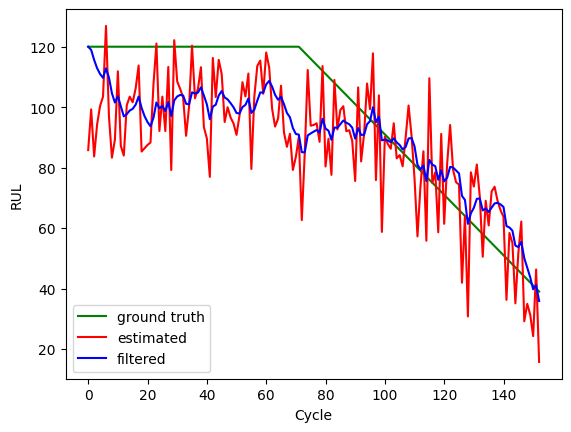

9/9 [==============================] - 0s 3ms/step


In [33]:
routes_kalman = []
rul_predicted=np.array([])
rul_truth=np.array([])
Score=0
#writer = pd.ExcelWriter('RUL_Test_FD004_Turbofan.xlsx', engine='xlsxwriter')
for route_test in routes_test:
    # Define a dictionary containing Students data 
    data = {} 
    # Convert the dictionary into DataFrame 
    df = pd.DataFrame(data)
    #Obtaining rul - groud truth
    truth_dataframe=routes_test[route_test]['RUL']
    truth=np.array(truth_dataframe.values.tolist())*RC
    rul_truth=np.append(rul_truth,truth)
    #Obtaining rul - predicted
    trajectory = routes_test[route_test][SENSOR_COLS].to_numpy()
    rul_trajectory=model.predict(trajectory)
    rul_trajectory = pd.DataFrame(rul_trajectory, columns=['rul'])
    z = np.array(rul_trajectory.values.tolist())
    # intial parameters
    n_iter = len(rul_trajectory)
    sz = (len(rul_trajectory),) # size of array
    # process variance
    #Q=1/209
    Q = 1/209
    # allocate space for arrays
    xhat=np.zeros(sz)      # a posteri estimate of x
    P=np.zeros(sz)         # a posteri error estimate
    xhatminus=np.zeros(sz) # a priori estimate of x
    Pminus=np.zeros(sz)    # a priori error estimate
    K=np.zeros(sz)         # gain or blending factor

    R = 0.3**2 # estimate of measurement variance, change to see effect
    # intial guesses
    #xhat[0] = 1
    xhat[0]=truth[0]/RC
    P[0] = 0.0

    for k in range(1,n_iter):
        # time update
        xhatminus[k] = xhat[k-1]
        Pminus[k] = P[k-1]+Q
        # measurement update
        K[k] = Pminus[k]/( Pminus[k]+R )
        xhat[k] = xhatminus[k]+K[k]*(z[k]-xhatminus[k])
        P[k] = (1-K[k])*Pminus[k]
        if(xhat[k]-truth[k]<0):
            score=math.exp((truth[k]-xhat[k])/13)-1;
        if (xhat[k]-truth[k]>=0):
            score=math.exp((xhat[k]-truth[k])/10)-1;
        Score=Score+score;
    
    xhat=xhat*RC
    rul_predicted=np.append(rul_predicted,xhat)
    routes_kalman.insert((unit_nr-1),xhat[(len(xhat)-1)])

    if route_test==TRAJECTORY:
        
        plt.figure()
        plt.plot(truth,'g-',label='ground truth')
        plt.plot(z*RC,'r-',label='estimate')
        plt.plot(xhat,'b-',label='a posteri estimate')
        plt.legend(['ground truth','estimated','filtered'])
        #plt.title('RUL vs cycle', fontweight='bold')
        plt.xlabel('Cycle')
        plt.ylabel('RUL')
        plt.show()
#writer.save()

In [34]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
mae=mean_absolute_error(rul_predicted,rul_truth)
mse=mean_squared_error(rul_predicted,rul_truth)
rmse=np.sqrt(mse)
print("GAUSSIAN KALMAN")
print("MAE:",mae)
print("MSE:",mse)
print("RMSE:",rmse)
#print("Score:",Score)

GAUSSIAN KALMAN
MAE: 22.142586100849
MSE: 819.9787994046293
RMSE: 28.63527194570761
